In [28]:
import tensorflow as tf
from tensorflow.keras import Sequential, layers
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

import pathlib
import os

import numpy as np

import matplotlib.pyplot as plt

In [29]:
data_dir = pathlib.Path(f'{os.getenv("HOME")}/code/data')

In [30]:
image_count = len(list(data_dir.glob('*/*AF7_4*.npy')))

In [31]:
image_count

1111

In [53]:
list_ds = tf.data.Dataset.list_files(str(data_dir/'*/*AF7_4*.npy'), shuffle=False)
list_ds = list_ds.shuffle(image_count, reshuffle_each_iteration=False)

In [54]:
for f in list_ds.take(5):
    print(f.numpy())

b'/home/vincent_moreau/code/data/nothing/AF7_4283_10.npy'
b'/home/vincent_moreau/code/data/nine/AF7_4634_9.npy'
b'/home/vincent_moreau/code/data/four/AF7_4084_4.npy'
b'/home/vincent_moreau/code/data/nothing/AF7_4165_10.npy'
b'/home/vincent_moreau/code/data/nothing/AF7_4211_10.npy'


In [55]:
class_names = np.array(sorted([item.name for item in data_dir.glob('*') if item.name != ".ipynb_checkpoints"]))
print(class_names)

['eight' 'five' 'four' 'nine' 'nothing' 'one' 'seven' 'six' 'three' 'two'
 'zero']


In [56]:
CONFIG = dict(test_split=.3,
              batch_size=32,
              img_height = 192,
              img_width = 256,
              n_channels = 3,
              n_classes = len(class_names)
              )

AUTOTUNE = tf.data.AUTOTUNE

In [57]:
val_size = int(image_count * CONFIG['test_split'])
train_ds = list_ds.skip(val_size)
val_ds = list_ds.take(val_size)

In [58]:
def get_label(file_path):
    parts = tf.strings.split(file_path, os.path.sep)
    one_hot = parts[-2] == class_names
    return tf.argmax(one_hot)

In [59]:
def decode_array(img):
    array = tf.numpy_function(np.load, [img], tf.uint8)
    return array

In [60]:
def process_path(file_path):
    label = get_label(file_path)
    array = decode_array(file_path)
    return array, label

In [61]:
def configure_for_performance(ds):
    ds = ds.cache()
    ds = ds.shuffle(buffer_size=1000)
    ds = ds.batch(CONFIG['batch_size'])
    ds = ds.prefetch(buffer_size=AUTOTUNE)
    return ds

In [62]:
train_ds = train_ds.map(process_path, num_parallel_calls=AUTOTUNE)
val_ds = val_ds.map(process_path, num_parallel_calls=AUTOTUNE)

In [63]:
train_ds = configure_for_performance(train_ds)
val_ds = configure_for_performance(val_ds)

nothing


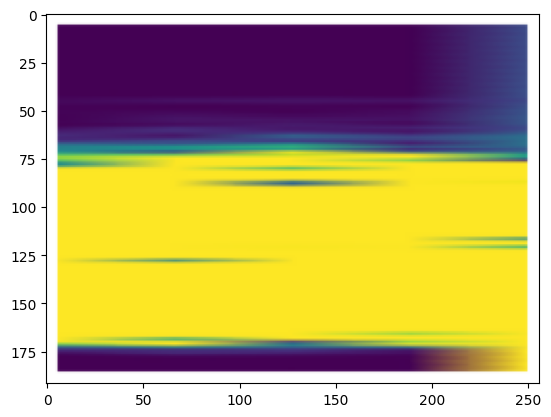

In [64]:
for image, label in train_ds.take(1):
    plt.imshow(image[0])
    print(class_names[label[0].numpy()])

In [65]:
def get_model_vanilla():
    
    input_shape = (CONFIG['img_height'], CONFIG['img_width'], CONFIG['n_channels'])
    
    model = tf.keras.Sequential([
        
        tf.keras.layers.Input(shape=input_shape),
        
        tf.keras.layers.Rescaling(1./255),
        
        tf.keras.layers.Conv2D(8, 5, activation='relu'),
        
        tf.keras.layers.MaxPooling2D(),
        
        tf.keras.layers.Conv2D(16, 3, activation='relu'),
        
        tf.keras.layers.MaxPooling2D(),
        
        tf.keras.layers.Conv2D(16, 2, activation='relu'),
        
        tf.keras.layers.MaxPooling2D(),
        
        tf.keras.layers.Flatten(),
        
        tf.keras.layers.Dense(16, activation='relu'),
        
        tf.keras.layers.Dropout(.3),

        tf.keras.layers.Dense(16, activation='relu'),
        
        tf.keras.layers.Dense(units=CONFIG['n_classes'], activation='softmax')
    ])
    return model

In [66]:
def get_model_custom():
    model = Sequential()

    input_shape = (CONFIG['img_height'], CONFIG['img_width'], CONFIG['n_channels'])
    
    model.add(layers.Input(shape=input_shape)),
    
    model.add(layers.Rescaling(1./255)),
    
    model.add(layers.Conv2D(16, (5, 5), activation='relu'))
    
    model.add(layers.MaxPool2D(pool_size=(2, 2)))

    model.add(layers.Conv2D(32, (3, 3), activation='relu'))
    
    model.add(layers.MaxPool2D(pool_size=(2, 2)))
    
    model.add(layers.Conv2D(64, (2, 2), activation='relu'))
    
    model.add(layers.MaxPool2D(pool_size=(2, 2)))
    
    model.add(layers.Flatten())
    
    model.add(layers.Dense(units=64, activation='relu'))
    
    model.add(layers.Dropout(0.3))

    model.add(layers.Dense(units=32, activation='relu'))

    model.add(layers.Dropout(0.1))

    model.add(layers.Dense(units=CONFIG['n_classes'], activation='softmax'))
    return model

def compile_model(model):
    model.compile(optimizer='adam',
                  loss=tf.losses.SparseCategoricalCrossentropy(from_logits=False),
                  metrics=['accuracy'])
    return model

In [67]:
model = get_model_vanilla()
model.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_4 (Rescaling)     (None, 192, 256, 3)       0         
                                                                 
 conv2d_12 (Conv2D)          (None, 188, 252, 8)       608       
                                                                 
 max_pooling2d_12 (MaxPoolin  (None, 94, 126, 8)       0         
 g2D)                                                            
                                                                 
 conv2d_13 (Conv2D)          (None, 92, 124, 16)       1168      
                                                                 
 max_pooling2d_13 (MaxPoolin  (None, 46, 62, 16)       0         
 g2D)                                                            
                                                                 
 conv2d_14 (Conv2D)          (None, 45, 61, 16)       

In [68]:
model = compile_model(model)

In [69]:
es = EarlyStopping(patience=20,
                   restore_best_weights=True)

In [70]:
chkpt = ModelCheckpoint(filepath=f'{os.getenv("HOME")}/code/checkpoints/model_checkpoint',
                        save_weights_only=True,
                        save_best_only=True,
                        monitor='val_loss',
                        mode='min')

In [71]:
model.fit(train_ds,
          validation_data=val_ds,
          callbacks = [es, chkpt],
          epochs=500)

Epoch 1/500
25/25 [==============================] - 15s 604ms/step - loss: 2.1845 - accuracy: 0.2841 - val_loss: 1.9329 - val_accuracy: 0.5435
Epoch 2/500
25/25 [==============================] - 15s 591ms/step - loss: 2.1035 - accuracy: 0.3856 - val_loss: 1.8945 - val_accuracy: 0.5435
Epoch 3/500
25/25 [==============================] - 15s 585ms/step - loss: 2.0215 - accuracy: 0.4743 - val_loss: 1.9639 - val_accuracy: 0.5435
Epoch 4/500
 1/25 [>.............................] - ETA: 13s - loss: 1.8595 - accuracy: 0.5312

2022-09-06 14:31:51.363367: W tensorflow/core/kernels/data/cache_dataset_ops.cc:768] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


KeyboardInterrupt: 